In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 2000)

In [2]:
# Define integer encoding for the 6 classes:
activity_to_code = {'dws': 0, 'ups': 1, 'sit': 2, 'std': 3, 'wlk': 4, 'jog': 5}
code_to_activity = {v:k for k,v in activity_to_code.items()}

# Load data

In [3]:
# df = pd.read_csv(r'../processed_data_100_25.csv')
# df = pd.read_csv(r'../processed_data_100_50.csv')
# df = pd.read_csv(r'../processed_data_200_50.csv')
# df = pd.read_csv(r'../processed_data_200_100.csv')
# df = pd.read_csv(r'../processed_data_300_75.csv')
# df = pd.read_csv(r'../processed_data_300_150.csv')

df = pd.read_csv(r'../processed_data_time_feat_only.csv')

df = df.drop(columns = ['index_range', 'subject', 'experiment'])

# Convert labels to numbers
df = df.replace(activity_to_code)

# Shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,attitude.roll_min,attitude.roll_max,attitude.roll_mean,attitude.roll_std,attitude.pitch_min,attitude.pitch_max,attitude.pitch_mean,attitude.pitch_std,attitude.yaw_min,attitude.yaw_max,attitude.yaw_mean,attitude.yaw_std,gravity.x_min,gravity.x_max,gravity.x_mean,gravity.x_std,gravity.y_min,gravity.y_max,gravity.y_mean,gravity.y_std,gravity.z_min,gravity.z_max,gravity.z_mean,gravity.z_std,rotationRate.x_min,rotationRate.x_max,rotationRate.x_mean,rotationRate.x_std,rotationRate.y_min,rotationRate.y_max,rotationRate.y_mean,rotationRate.y_std,rotationRate.z_min,rotationRate.z_max,rotationRate.z_mean,rotationRate.z_std,userAcceleration.x_min,userAcceleration.x_max,userAcceleration.x_mean,userAcceleration.x_std,userAcceleration.y_min,userAcceleration.y_max,userAcceleration.y_mean,userAcceleration.y_std,userAcceleration.z_min,userAcceleration.z_max,userAcceleration.z_mean,userAcceleration.z_std,activity
0,0.019039,0.044853,0.032353,7.584721e-03,-0.031235,-0.028578,-0.029923,0.000779,1.278244,1.278244,1.278244,5.388364e-16,-0.011106,-0.004533,-0.007803,1.926755e-03,0.923352,0.923352,0.923352,4.662456e-16,0.021101,0.025117,0.023140,1.177363e-03,-0.002678,0.045208,0.012315,0.016927,-0.081207,0.048829,-0.013871,0.044238,-0.032986,0.016603,-0.009959,0.013563,0.004522,0.005160,0.004842,1.869965e-04,0.001584,0.001807,0.001696,6.548607e-05,0.078449,0.078449,0.078449,3.217055e-17,3
1,-0.014465,-0.013848,-0.014171,1.813029e-04,-0.017566,-0.015623,-0.016603,0.000570,0.331643,0.331643,0.331643,1.793134e-16,-0.002649,-0.000879,-0.001781,5.218358e-04,0.200118,0.200118,0.200118,7.364598e-17,0.817307,0.817307,0.817307,5.688474e-16,-0.017447,0.016551,0.001928,0.008847,-0.036574,0.026649,-0.001682,0.015769,-0.016323,0.017436,0.000300,0.008815,0.014440,0.014440,0.014440,5.988991e-18,-0.015433,-0.013725,-0.014586,5.004527e-04,0.013870,0.013870,0.013870,6.119529e-18,2
2,1.531143,1.531143,1.531143,5.552236e-16,0.006996,0.007923,0.007412,0.000297,1.465681,1.465681,1.465681,4.884166e-16,0.080672,0.080672,0.080672,2.878773e-17,0.990593,0.990593,0.990593,3.272215e-16,0.077959,0.077959,0.077959,2.902329e-17,-0.053981,0.033526,-0.010942,0.026735,-0.063041,0.064826,-0.016559,0.043301,-0.018868,0.028183,-0.001233,0.012466,-0.019399,0.025399,-0.000162,1.043148e-02,0.012896,0.012896,0.012896,6.198494e-18,-0.002334,0.006856,0.001710,3.046523e-03,3
3,-0.207439,0.833110,0.259918,3.326304e-01,-0.154554,0.157476,0.003701,0.091748,-0.760968,0.609563,-0.008242,3.532480e-01,-0.046230,0.051693,0.004393,2.460100e-02,0.919775,0.919775,0.919775,3.347448e-16,-0.327077,0.327057,-0.005808,2.357698e-01,-0.983810,1.171335,0.026648,0.524877,-1.596600,1.577340,0.024615,0.860534,-0.432917,0.398512,-0.011683,0.218399,-0.138024,0.173356,-0.002543,8.218171e-02,-0.000345,0.270873,0.138372,9.799598e-02,0.209911,0.209911,0.209911,2.789540e-17,4
4,0.007087,0.007328,0.007209,7.079101e-05,0.005003,0.005175,0.005092,0.000050,0.000181,0.001691,0.001007,5.508310e-04,0.003478,0.003646,0.003567,4.916836e-05,0.093611,0.093611,0.093611,1.797036e-17,0.884307,0.884307,0.884307,3.161917e-16,-0.005794,0.011840,0.002054,0.004959,-0.018893,0.030391,0.001442,0.011267,-0.012418,0.019123,-0.000363,0.006999,0.001996,0.001996,0.001996,4.423553e-19,-0.004769,0.005081,-0.000119,2.784120e-03,-0.004097,0.005817,0.000011,2.739666e-03,2


# Split data and label and initialize StratifiedKfold

In [4]:
data = df.drop(columns = ['activity']).to_numpy()
label = df['activity'].to_numpy()

skf = StratifiedKFold(5)

In [5]:
print(data.shape)
print(label.shape)

(55247, 48)
(55247,)


# Create MLP model

In [6]:
MLP = keras.Sequential([
    keras.layers.Dense(48, input_shape=(48,), activation='relu'),  # input layer (1) & hidden layer (2)
    keras.layers.Dense(24, activation='relu'), # hidden layer(3)
    keras.layers.Dense(6, activation='softmax') # output layer (4)
])

In [7]:
MLP.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48)                2352      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 150       
Total params: 3,678
Trainable params: 3,678
Non-trainable params: 0
_________________________________________________________________


# Train MLP model with stratifiedKfold cross validation

In [9]:
accuracies = []
matrixes = []
attempt = 1

initial_weights = MLP.get_weights()

for train_index, test_index in skf.split(data, label):
    # reset model weights
    MLP.set_weights(initial_weights)
    
    print("TRAIN ATTEMPT: ", attempt)
    attempt = attempt + 1
    
    # Split data into train and test
    train, train_label = data[train_index], label[train_index]
    test, test_label = data[test_index], label[test_index]
    
    # Train model
    MLP.fit(train, train_label, epochs=5)

    # Record evaluation accuracy
    eval_loss, eval_acc = MLP.evaluate(test, test_label, verbose=1)
    accuracies.append(eval_acc)

    # Record confusion matrix
    predict_label = MLP.predict_classes(test)
    matrix = confusion_matrix(y_true=test_label, y_pred=predict_label)
    matrixes.append(matrix)
    
    

accuracies = np.around(accuracies, decimals = 4)
print("Accuracy values: ", accuracies)
print("Average accuracy: ", np.mean(accuracies))

TRAIN ATTEMPT:  1
Epoch 1/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.3049 - accuracy: 0.9062
Epoch 2/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.0839 - accuracy: 0.9746
Epoch 3/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.0579 - accuracy: 0.9812
Epoch 4/5
1382/1382 [==============================] - 2s 2ms/step - loss: 0.0439 - accuracy: 0.9861
Epoch 5/5
346/346 [==============================] - 0s 1ms/step - loss: 0.0353 - accuracy: 0.9874
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
TRAIN ATTEMPT:  2
Epoch 1/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.2617 - accuracy: 0.9163
Epoch 2/5
1382/1382 [=====

# Inspect Confusion Matrix

<ipython-input-10-971670ff339f>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp.set_xticklabels(activities, fontsize = "x-large")
<ipython-input-10-971670ff339f>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp.set_yticklabels(activities, fontsize = "x-large")


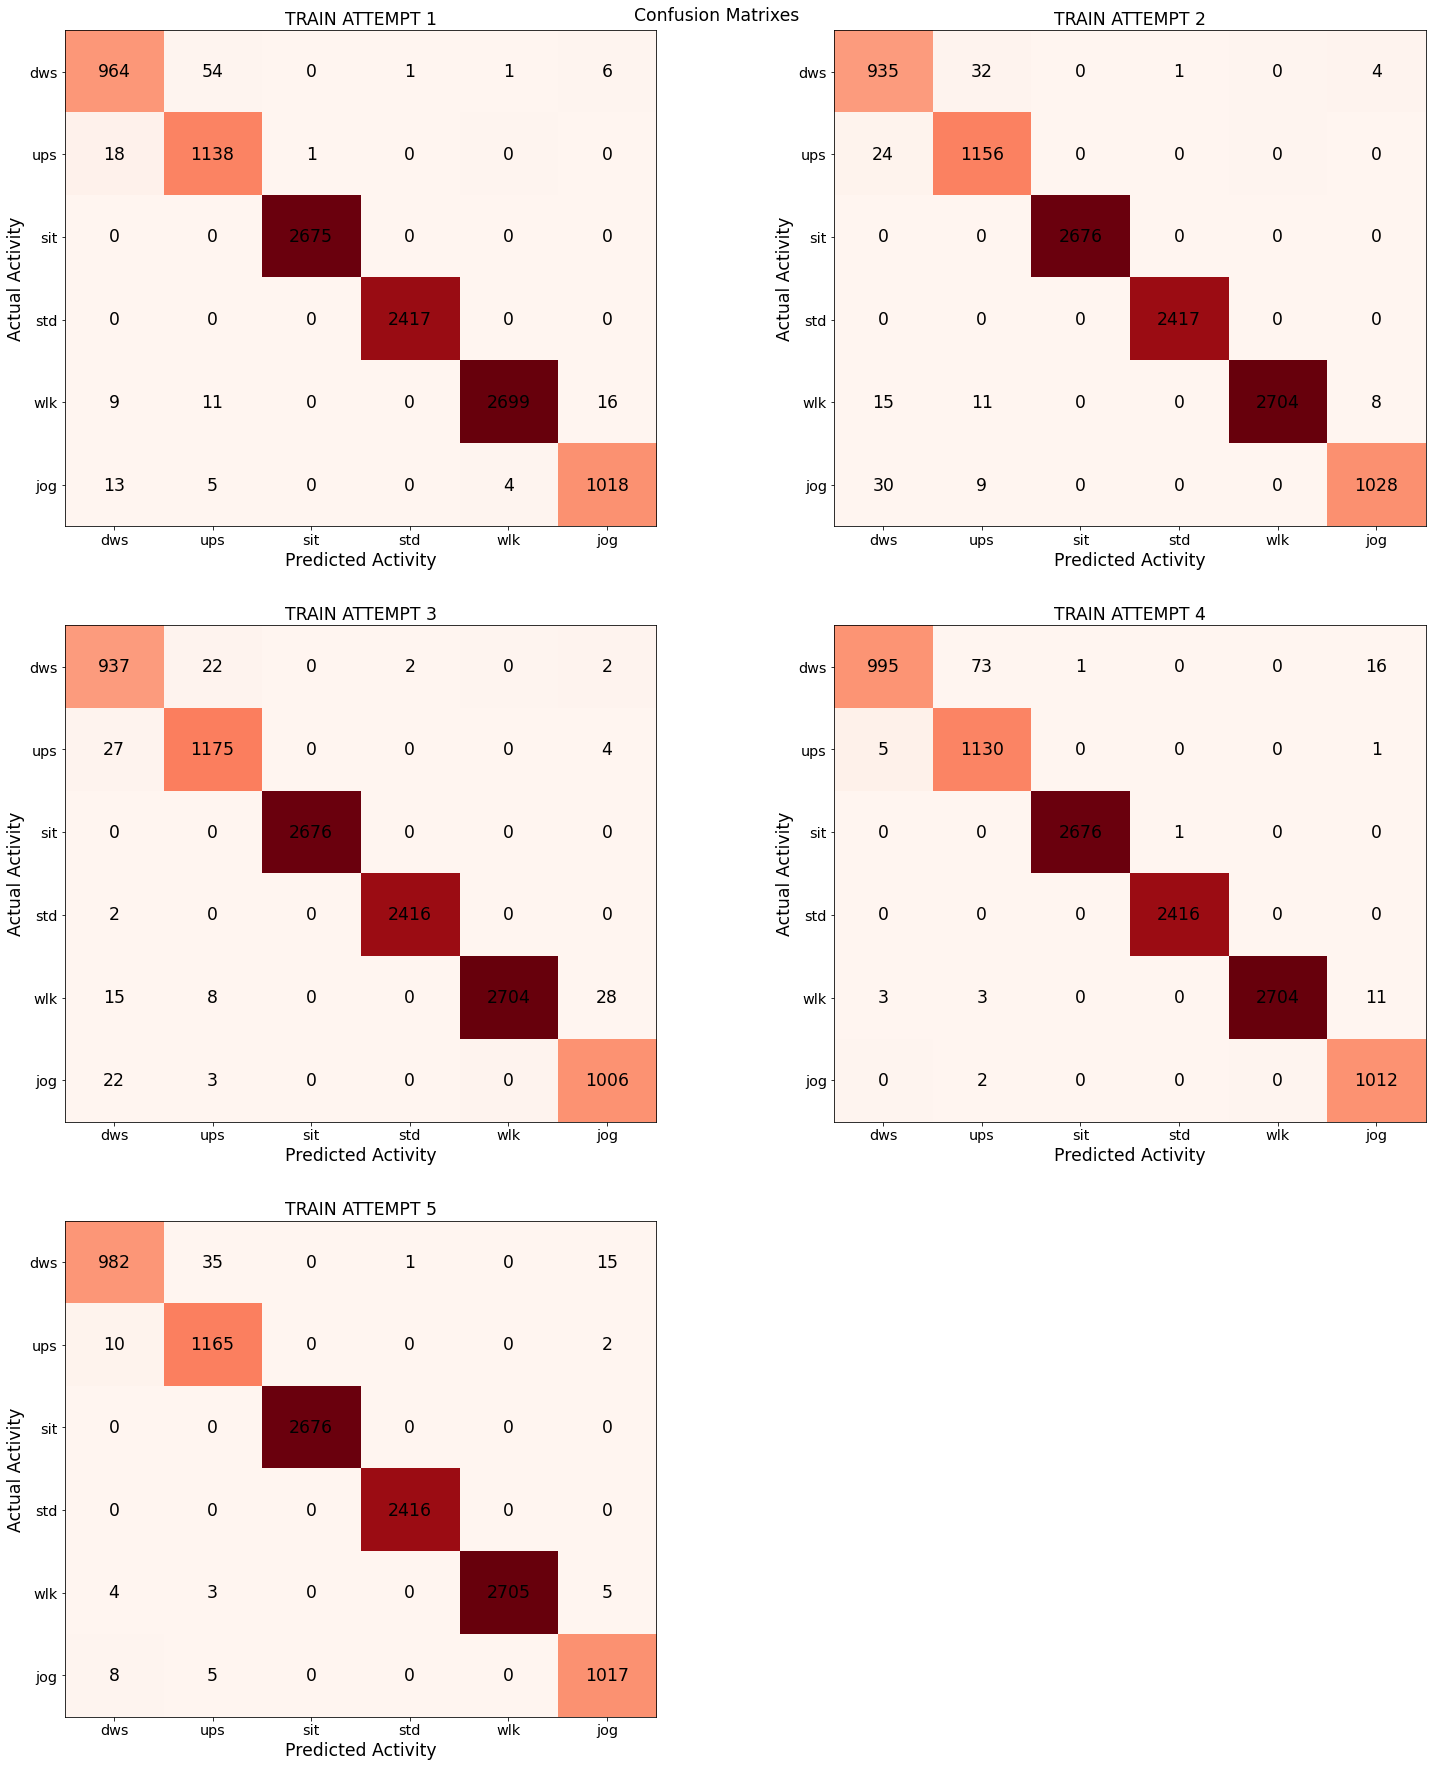

In [10]:
activities = ['dws', 'dws', 'ups', 'sit', 'std', 'wlk', 'jog']

fig = plt.figure(figsize = (20,25))
fig.suptitle("Confusion Matrixes", fontsize = "xx-large")

for index, m in enumerate(matrixes):
    sp = fig.add_subplot(3,2,index + 1)
    sp.imshow(m, cmap="Reds", aspect='auto')
    sp.set_title("TRAIN ATTEMPT " + str(index + 1), fontsize = "xx-large")

    for i in range(6):
        for j in range(6):
            sp.text(i, j, m[i, j], ha="center", va="center", color="black", fontsize = "xx-large")

    sp.set_xticklabels(activities, fontsize = "x-large")
    sp.set_yticklabels(activities, fontsize = "x-large")
    
    sp.set_ylabel("Actual Activity", fontsize = "xx-large")
    sp.set_xlabel("Predicted Activity", fontsize = "xx-large")

fig.tight_layout()
fig.subplots_adjust(wspace = 0.3, hspace = 0.2)
plt.show()

# Export model

In [11]:
MLP.save("MLP.h5")

# Testing prediction

In [12]:
MLP.predict_classes(data[0:1])

array([3], dtype=int64)

In [13]:
print(label[0:1])

[3]
